# 스마트쉘터입지선정을 위한 데이터 분석

1. Preprocessing
  * 인구 데이터를 나이별 3 class로 분리(청소년,성인,노인)
  * 

In [ ]:
# data preprocessing
import numpy as np
import pandas as pd

##총 5가지 데이터 활용.
1. df_businfo : 버스정보 안내기
2. df_stationinfo : 버스 정류소 위치정보
3. df_schedule : 버스 배차 정보
4. df_busbig : 빅데이터 버스정보
5. df_popul: 창원시 읍면동 행정동별 인구

In [ ]:
df_businfo = pd.read_csv('/content/경상남도 창원시 버스정보안내기 설치현황_20210923.csv',encoding = 'cp949')
df_schedule = pd.read_csv('/content/경상남도 창원시_버스배차정보.csv',encoding = 'cp949')
df_stationinfo = pd.read_csv('/content/경상남도 창원시_버스정류소 위치정보_20220504.csv',encoding = 'cp949')
df_busbig = pd.read_csv('/content/경상남도 창원시_빅데이터_버스정보_20180101.csv',encoding = 'cp949')
df_popul = pd.read_csv('/content/경상남도 창원시_읍면동 행정동별 인구(1세 단위)_20220731.csv',encoding = 'cp949')

창원시 읍면동 행정동별 인구 데이터 3class로 분리

In [ ]:
df_popul_n = df_popul.copy()

# 연령데이터 전처리: 0세 -> 0 (int값으로 만들기 위한 전처리)
df_popul_n['연령(만)'] = df_popul_n['연령(만)'].apply(lambda x:x.split()[0]).apply(lambda x: int("".join((list(x)[:-1]))))
# 남,녀 column drop
df_popul_n = df_popul_n.drop(['남','녀'],axis=1)

df_popul_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6105 entries, 0 to 6104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정기관    6105 non-null   object
 1   연령(만)   6105 non-null   int64 
 2   합계      6105 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 143.2+ KB


In [ ]:
# 인구 데이터를 연령에 따라 청소년, 성인, 노인으로 변경
def classify_age(x):
  if 9 <=x<20:
    return '청소년'
  elif 21<=x<65:
    return '성인'
  elif 65<=x<81:
    return '노인'
  else:
    return np.nan
df_popul_n ['연령(만)'] = df_popul_n['연령(만)'].apply(classify_age)
df_popul_nn = df_popul_n.dropna()
df_popul_nn = df_popul_nn[['행정기관','연령(만)','합계']].groupby(by = ['행정기관','연령(만)']).sum()
df_popul_nn

합계
행정기관 연령(만)       
가음정동 노인      3054
     성인     28562
     청소년     4191
가포동  노인       340
     성인      1280
...           ...
회원1동 성인      5801
     청소년      669
회원2동 노인      2702
     성인      5801
     청소년      669

[165 rows x 1 columns]

#### 나이에 따라 가중치를 설정
* 청소년 가중치 0.8
* 성인 가중치 1
* 노인 가중치 1.2

In [ ]:
def weight_age(x):
  if 9 <=x<20:
    return x*0.8
  elif 21<=x<65:
    return x
  elif 65<=x<81:
    return x*1.2
  else:
    return np.nan

df_popul_nn = df_popul_n.dropna()
df_popul_nn.loc[df_popul_nn['연령(만)'] == '청소년', '합계'] = df_popul_nn['합계']*0.8
df_popul_nn.loc[df_popul_nn['연령(만)'] == '노인', '합계'] = df_popul_nn['합계']*1.2

df_popul_nn = df_popul_nn[['행정기관','연령(만)','합계']].groupby('행정기관')['합계'].sum()

df_popul_nn = df_popul_nn.to_frame()
# 2개동으로 나눠진 것을 한동으로 통합
df_popul_nn.loc['합성동','합계'] = df_popul_nn.loc['합성1동','합계'] + df_popul_nn.loc['합성2동','합계']
df_popul_nn.loc['구암동','합계'] = df_popul_nn.loc['구암1동','합계'] + df_popul_nn.loc['구암2동','합계']
df_popul_nn.shape

(57, 1)

In [ ]:
# 버스배차 정보데이터 전처리
df_schedule_n = df_schedule.dropna()
# 기점지, 경유지, 종점지, 간격 column drop
df_schedule_n = df_schedule_n.drop(labels = ['기점지','경유지','종점지 ','간격'],axis = 1)
# 가중치: 대수 * 횟수
df_schedule_n['대수*횟수'] = df_schedule_n['대수'].mul(df_schedule_n['횟수'])
df_schedule_n

,종류,노선,대수,횟수,대수*횟수
0,간선좌석(급행 및 직행좌석),800(급행),15.0,90.0,1350.0
1,간선좌석(급행 및 직행좌석),801(급행),7.0,35.0,245.0
2,간선좌석(급행 및 직행좌석),860(급행),4.0,16.0,64.0
3,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0
4,간선좌석(급행 및 직행좌석),704,11.0,66.0,726.0
...,...,...,...,...,...
140,기타노선(마을버스),8,5.0,119.0,595.0
141,기타노선(마을버스),350,1.0,124.0,124.0
142,기타노선(마을버스),351,1.0,7.0,7.0
143,기타노선(마을버스),352,1.0,11.0,11.0


In [ ]:
# 버스배차 정보데이터에 정류장명을 넣어주는 과정
df_new = pd.merge(df_schedule_n,df_busbig,how='inner',on = '노선')
# 연번 column drop
df_new = df_new.drop('연번', axis = 1)
df_new = df_new.dropna()
df_new

,종류,노선,대수,횟수,대수*횟수,정류장코드,정류장명
0,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4811782,상남도서관
1,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4816670,롯데백화점앞어시장
2,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4802902,창원역
3,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4814302,명서동허앤리병원
4,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4805932,은아아파트
...,...,...,...,...,...,...,...
13053,기타노선(마을버스),353,1.0,7.0,7.0,4828183,부영4단지
13054,기타노선(마을버스),353,1.0,7.0,7.0,4804403,㈜태광
13055,기타노선(마을버스),353,1.0,7.0,7.0,4807353,용원복지회관
13056,기타노선(마을버스),353,1.0,7.0,7.0,4828043,신항초등학교


In [ ]:
# 방면, 순번 column drop
df_stationinfo_loc = df_stationinfo
df_stationinfo_loc = df_stationinfo_loc.drop(labels =['방면', '순번'], axis = 1)
df_stationinfo_loc = df_stationinfo_loc.dropna()
# 정류소 아이디 int로 변경
df_stationinfo_loc = df_stationinfo_loc.astype({'정류소 아이디':int})
df_stationinfo_loc

,정류소 아이디,정류소명,X좌표,Y좌표
0,630332,(주)에스에이치아이,128.765729,35.086850
1,630300,(주)태광,128.831487,35.090638
2,630301,(주)태광,128.831298,35.090315
3,104710,1366경남센터,128.598680,35.312734
4,104709,1366경남센터,128.598596,35.312917
...,...,...,...,...
2921,119304,흥한웰가아파트,128.618190,35.264465
2922,119303,흥한웰가아파트,128.617951,35.264309
2923,103103,힐스테이트1차,128.597439,35.302354
2924,103115,힐스테이트3차,128.587808,35.302336


In [ ]:
# 모바일 ID를 아이디 중복 제거
df_businfo_n = df_businfo.copy()
df_businfo_n['모바일ID'] = df_businfo_n['모바일ID'].apply(lambda x:x.split(',')[0])
df_businfo_n.dropna(inplace=True)
# ID coulmn drop
df_businfo_n = df_businfo_n.drop(labels =['ID'], axis = 1)
# 정류소 아이디 str로 변경
df_stationinfo_loc = df_stationinfo_loc.astype({'정류소 아이디':'str'})
df_businfo_n

,모바일ID,설치정류소명,주소
0,115302,창원역(맞은편),의창구 동정동 156-3
1,114202,도계동.의창스포츠센터,의창구 도계동 465-3
2,114201,도계동.의창스포츠센터(창원씨엘여성병원),의창구 도계동 333-4
3,115316,"도계동만남의광장(매점 내부, 김해방면)",의창구 도계동 305-7
4,114210,명서다리.명곡교회(맞은편),의창구 명서동 131-4
...,...,...,...
1142,511102,부영2차아파트,진해구 청안동 474
1143,511003,코아루아파트(부영1차A앞),진해구 청안동 477
1144,511005,안골포초등학교(앞),진해구 청안동 475
1145,518142,풍호동사거리,진해구 풍호동 810


In [ ]:
# businfo(모바일ID)와 stationinfo(정류소 아이디)의 같은 값을 기준으로 merge
# 버스정보 안내기가 설치된 정류소의 X좌표, Y좌표를 구하기 위해서
df_businfo_u = pd.merge(df_businfo_n,df_stationinfo_loc,left_on = '모바일ID',right_on='정류소 아이디')
df_businfo_u

,모바일ID,설치정류소명,주소,정류소 아이디,정류소명,X좌표,Y좌표
0,115302,창원역(맞은편),의창구 동정동 156-3,115302,창원역,128.607238,35.256602
1,114202,도계동.의창스포츠센터,의창구 도계동 465-3,114202,도계동.의창스포츠센터,128.634411,35.256812
2,114201,도계동.의창스포츠센터(창원씨엘여성병원),의창구 도계동 333-4,114201,도계동.의창스포츠센터,128.633624,35.258201
3,115316,"도계동만남의광장(매점 내부, 김해방면)",의창구 도계동 305-7,115316,도계동만남의광장,128.632254,35.261516
4,115316,"도계동만남의광장(매점 앞, 김해방면)",의창구 도계동 305-7,115316,도계동만남의광장,128.632254,35.261516
...,...,...,...,...,...,...,...
1141,630252,어은동(부성자동차운전학원앞),진해구 죽곡동 134-4,630252,어은동,128.728962,35.114501
1142,511102,부영2차아파트,진해구 청안동 474,511102,부영2차아파트,128.804793,35.104132
1143,511003,코아루아파트(부영1차A앞),진해구 청안동 477,511003,코아루아파트,128.806265,35.101578
1144,511005,안골포초등학교(앞),진해구 청안동 475,511005,안골포초등학교,128.806378,35.103799


In [ ]:
# businfo(정류소명)와 new(정류장명)의 같은 값을 기준으로 merge
# 버스정보안내기 데이터에 가중치(대수 * 횟수)를 붙이기 위해
df_bus = pd.merge(df_businfo_u,df_new, left_on = '정류소명',right_on='정류장명')
df_bus

,모바일ID,설치정류소명,주소,정류소 아이디,정류소명,X좌표,Y좌표,종류,노선,대수,횟수,대수*횟수,정류장코드,정류장명
0,115302,창원역(맞은편),의창구 동정동 156-3,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4802902,창원역
1,115302,창원역(맞은편),의창구 동정동 156-3,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4802892,창원역
2,115302,창원역(맞은편),의창구 동정동 156-3,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),710,12.0,69.0,828.0,4802902,창원역
3,115302,창원역(맞은편),의창구 동정동 156-3,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),710,12.0,69.0,828.0,4802892,창원역
4,115302,창원역(맞은편),의창구 동정동 156-3,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),757,10.0,40.0,400.0,4802902,창원역
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16008,630206,동진여중,진해구 자은동 657-35,630206,동진여중,128.704986,35.143170,"시내 지선,순환(일반버스)",301,5.0,75.0,375.0,4815473,동진여중
16009,511102,부영2차아파트,진해구 청안동 474,511102,부영2차아파트,128.804793,35.104132,간선좌석(급행 및 직행좌석),757,10.0,40.0,400.0,4812923,부영2차아파트
16010,511102,부영2차아파트,진해구 청안동 474,511102,부영2차아파트,128.804793,35.104132,"시내 지선,순환(일반버스)",305,10.0,63.0,630.0,4812923,부영2차아파트
16011,511102,부영2차아파트,진해구 청안동 474,511102,부영2차아파트,128.804793,35.104132,"시내 지선,순환(일반버스)",315,7.0,48.5,339.5,4812923,부영2차아파트


In [ ]:
# 주소 데이터 전처리
df_bus1 = df_bus.copy()
df_bus1['주소'] = df_bus1['주소'].str.split(' ').str[1]

# 행정동에 맞게 변환
# 읍면동 인구 데이터와 주소값을 같게 만들기 위해서
df_bus1.loc[df_bus1['주소'] == '가음동', '주소'] = '가음정동'
df_bus1.loc[df_bus1['주소'] == '고운로', '주소'] = '반월중앙동'
df_bus1.loc[df_bus1['주소'] == '공단로', '주소'] = '웅남동'
df_bus1.loc[df_bus1['주소'] == '광화동', '주소'] = '충무동'
df_bus1.loc[df_bus1['주소'] == '귀곡동', '주소'] = '웅남동'
df_bus1.loc[df_bus1['주소'] == '남문동', '주소'] = '웅천동'
df_bus1.loc[df_bus1['주소'] == '남산동', '주소'] = '성주동'
df_bus1.loc[df_bus1['주소'] == '남성동', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '남양동', '주소'] = '가음정동'
df_bus1.loc[df_bus1['주소'] == '내동', '주소'] = '중앙동'
df_bus1.loc[df_bus1['주소'] == '대방동', '주소'] = '사파동'
df_bus1.loc[df_bus1['주소'] == '대원동', '주소'] = '팔룡동'
df_bus1.loc[df_bus1['주소'] == '대흥동', '주소'] = '충무동'
df_bus1.loc[df_bus1['주소'] == '덕동동', '주소'] = '현동'
df_bus1.loc[df_bus1['주소'] == '덕정동', '주소'] = '팔룡동'
df_bus1.loc[df_bus1['주소'] == '도계동', '주소'] = '명곡동'
df_bus1.loc[df_bus1['주소'] == '동성동', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '동전리', '주소'] = '북면'
df_bus1.loc[df_bus1['주소'] == '동정동', '주소'] = '의창동'
df_bus1.loc[df_bus1['주소'] == '두대동', '주소'] = '중앙동'
df_bus1.loc[df_bus1['주소'] == '두동', '주소'] = '웅동1동'
df_bus1.loc[df_bus1['주소'] == '두척동', '주소'] = '회성동'
df_bus1.loc[df_bus1['주소'] == '마천동', '주소'] = '웅동1동'
df_bus1.loc[df_bus1['주소'] == '모산리', '주소'] = '대산면'
df_bus1.loc[df_bus1['주소'] == '명동', '주소'] = '웅천동'
df_bus1.loc[df_bus1['주소'] == '명서동', '주소'] = '명곡동'
df_bus1.loc[df_bus1['주소'] == '반림동', '주소'] = '반송동'
df_bus1.loc[df_bus1['주소'] == '반월동', '주소'] = '반월중앙동'
df_bus1.loc[df_bus1['주소'] == '반지동', '주소'] = '반송동'
df_bus1.loc[df_bus1['주소'] == '봉곡동', '주소'] = '봉림동'
df_bus1.loc[df_bus1['주소'] == '북동', '주소'] = '의창동'
df_bus1.loc[df_bus1['주소'] == '북부동', '주소'] = '웅천동'
df_bus1.loc[df_bus1['주소'] == '사림동', '주소'] = '봉림동'
df_bus1.loc[df_bus1['주소'] == '삼동동', '주소'] = '중앙동'
df_bus1.loc[df_bus1['주소'] == '서상동', '주소'] = '의창동'
df_bus1.loc[df_bus1['주소'] == '서성동', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '석전1동', '주소'] = '석전동'
df_bus1.loc[df_bus1['주소'] == '성내동', '주소'] = '웅천동'
df_bus1.loc[df_bus1['주소'] == '성산동', '주소'] = '웅남동'
df_bus1.loc[df_bus1['주소'] == '성호동', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '소계동', '주소'] = '북면'
df_bus1.loc[df_bus1['주소'] == '소답동', '주소'] = '의창동'
df_bus1.loc[df_bus1['주소'] == '수송동', '주소'] = '충무동'
df_bus1.loc[df_bus1['주소'] == '수성동', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '신월동', '주소'] = '용지동'
df_bus1.loc[df_bus1['주소'] == '신촌동', '주소'] = '웅남동'
df_bus1.loc[df_bus1['주소'] == '신포동1가', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '신포동2가', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '안민동', '주소'] = '성주동'
df_bus1.loc[df_bus1['주소'] == '안골동', '주소'] = '웅동2동'
df_bus1.loc[df_bus1['주소'] == '양곡동', '주소'] = '웅남동'
df_bus1.loc[df_bus1['주소'] == '양덕동', '주소'] = '양덕1동'
df_bus1.loc[df_bus1['주소'] == '예곡동', '주소'] = '월영동'
df_bus1.loc[df_bus1['주소'] == '외동', '주소'] = '중앙동'
df_bus1.loc[df_bus1['주소'] == '용동', '주소'] = '봉림동'
df_bus1.loc[df_bus1['주소'] == '용원동', '주소'] = '웅동2동'
# df_bus1.loc[df_bus1['주소'] == '용동동', '주소'] = '웅동2동'
df_bus1.loc[df_bus1['주소'] == '용호동', '주소'] = '용지동'
df_bus1.loc[df_bus1['주소'] == '웅동로', '주소'] = '웅동1동'
df_bus1.loc[df_bus1['주소'] == '우산동', '주소'] = '현동'
df_bus1.loc[df_bus1['주소'] == '월남동1가', '주소'] = '문화동'
df_bus1.loc[df_bus1['주소'] == '월남동2가', '주소'] = '문화동'
df_bus1.loc[df_bus1['주소'] == '월남동3가', '주소'] = '문화동'
df_bus1.loc[df_bus1['주소'] == '장천동', '주소'] = '풍호동'
df_bus1.loc[df_bus1['주소'] == '죽곡동', '주소'] = '웅천동'
df_bus1.loc[df_bus1['주소'] == '중동', '주소'] = '의창동'
df_bus1.loc[df_bus1['주소'] == '중성동', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '중앙동1가', '주소'] = '반월중앙동'
df_bus1.loc[df_bus1['주소'] == '중앙동2가', '주소'] = '반월중앙동'
df_bus1.loc[df_bus1['주소'] == '중앙동3가', '주소'] = '반월중앙동'
df_bus1.loc[df_bus1['주소'] == '진동리', '주소'] = '진동면'
df_bus1.loc[df_bus1['주소'] == '천선동', '주소'] = '성주동'
df_bus1.loc[df_bus1['주소'] == '청안동', '주소'] = '웅동2동'
df_bus1.loc[df_bus1['주소'] == '추산동', '주소'] = '오동동'
df_bus1.loc[df_bus1['주소'] == '태봉리', '주소'] = '진동면'
df_bus1.loc[df_bus1['주소'] == '태평동', '주소'] = '충무동'
df_bus1.loc[df_bus1['주소'] == '토월동', '주소'] = '사파동'
df_bus1.loc[df_bus1['주소'] == '통신동', '주소'] = '충무동'
df_bus1.loc[df_bus1['주소'] == '퇴촌동', '주소'] = '동읍'
df_bus1.loc[df_bus1['주소'] == '평화동', '주소'] = '문화동'
df_bus1.loc[df_bus1['주소'] == '해운동', '주소'] = '월영동'
df_bus1.loc[df_bus1['주소'] == '행암동', '주소'] = '풍호동'
df_bus1.loc[df_bus1['주소'] == '화천동', '주소'] = '충무동'
df_bus1.loc[df_bus1['주소'] == '팔용동', '주소'] = '의창동'
df_bus1.loc[df_bus1['정류소명'] == '한국전력', '주소'] = '구암2동'
df_bus1.loc[df_bus1['정류소명'] == '구암동', '주소'] = '구암1동'
df_bus1.loc[df_bus1['정류소명'] == '대지아파트', '주소'] = '구암1동'
df_bus1.loc[df_bus1['정류소명'] == '구암2동주민센터', '주소'] = '구암2동'
df_bus1.loc[df_bus1['정류소명'] == '구암고등학교', '주소'] = '구암2동'
df_bus1.loc[df_bus1['정류소명'] == '구암동현대상가', '주소'] = '구암2동'
df_bus1.loc[df_bus1['정류소명'] == '창신대학교입구', '주소'] = '구암2동'
df_bus1.loc[df_bus1['정류소명'] == '구암동육교', '주소'] = '구암2동'
df_bus1.loc[df_bus1['정류소명'] == '삼성창원병원', '주소'] = '구암2동'
df_bus1.loc[df_bus1['정류소명'] == '수영아파트', '주소'] = '구암1동'
df_bus1

,모바일ID,설치정류소명,주소,정류소 아이디,정류소명,X좌표,Y좌표,종류,노선,대수,횟수,대수*횟수,정류장코드,정류장명
0,115302,창원역(맞은편),의창동,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4802902,창원역
1,115302,창원역(맞은편),의창동,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),703,13.0,75.0,975.0,4802892,창원역
2,115302,창원역(맞은편),의창동,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),710,12.0,69.0,828.0,4802902,창원역
3,115302,창원역(맞은편),의창동,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),710,12.0,69.0,828.0,4802892,창원역
4,115302,창원역(맞은편),의창동,115302,창원역,128.607238,35.256602,간선좌석(급행 및 직행좌석),757,10.0,40.0,400.0,4802902,창원역
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16008,630206,동진여중,자은동,630206,동진여중,128.704986,35.143170,"시내 지선,순환(일반버스)",301,5.0,75.0,375.0,4815473,동진여중
16009,511102,부영2차아파트,웅동2동,511102,부영2차아파트,128.804793,35.104132,간선좌석(급행 및 직행좌석),757,10.0,40.0,400.0,4812923,부영2차아파트
16010,511102,부영2차아파트,웅동2동,511102,부영2차아파트,128.804793,35.104132,"시내 지선,순환(일반버스)",305,10.0,63.0,630.0,4812923,부영2차아파트
16011,511102,부영2차아파트,웅동2동,511102,부영2차아파트,128.804793,35.104132,"시내 지선,순환(일반버스)",315,7.0,48.5,339.5,4812923,부영2차아파트


In [ ]:
# 코드 통합
df_comp1 = pd.merge(df_bus1,df_popul_nn,left_on = '주소',right_on = '행정기관',how = 'left')

# 필요한 column만 남기고 제거 및 중복 제거
df_comp = df_comp1[['모바일ID','정류장명','주소','X좌표','Y좌표','대수*횟수','합계']]
df_comp = df_comp.drop_duplicates(subset=['정류장명'])
df_comp = df_comp.dropna()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy as sp
import seaborn as snss
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# training data 생산
df_train = df_comp.copy()
df_train.columns = ['ID','busStation','address','x','y','number','total']
df_train = df_train.reset_index()

# data scale
df_train_eq = df_train[['x','y','number','total']]
df_train_cl = df_train[['x','y']]
minmax_scaler = MinMaxScaler()
df_train_eq_mms = minmax_scaler.fit_transform(df_train_eq)
df_train_eq_mms = pd.DataFrame(df_train_eq_mms,columns = df_train_eq.columns)

In [ ]:
# K-means training, seed 값 20개

model = KMeans(n_clusters=20,algorithm='auto')
model.fit(df_train_cl)
predict = pd.DataFrame(model.predict(df_train_cl))
predict.columns=['predict']
res = pd.concat([df_train_cl,predict],axis=1)
res

,x,y,predict
0,128.607238,35.256602,4
1,128.632254,35.261516,4
2,128.643917,35.245863,17
3,128.617951,35.264309,4
4,128.659437,35.244778,17
...,...,...,...
597,128.662089,35.164016,0
598,128.670975,35.153762,0
599,128.711163,35.154770,14
600,128.705164,35.143197,14


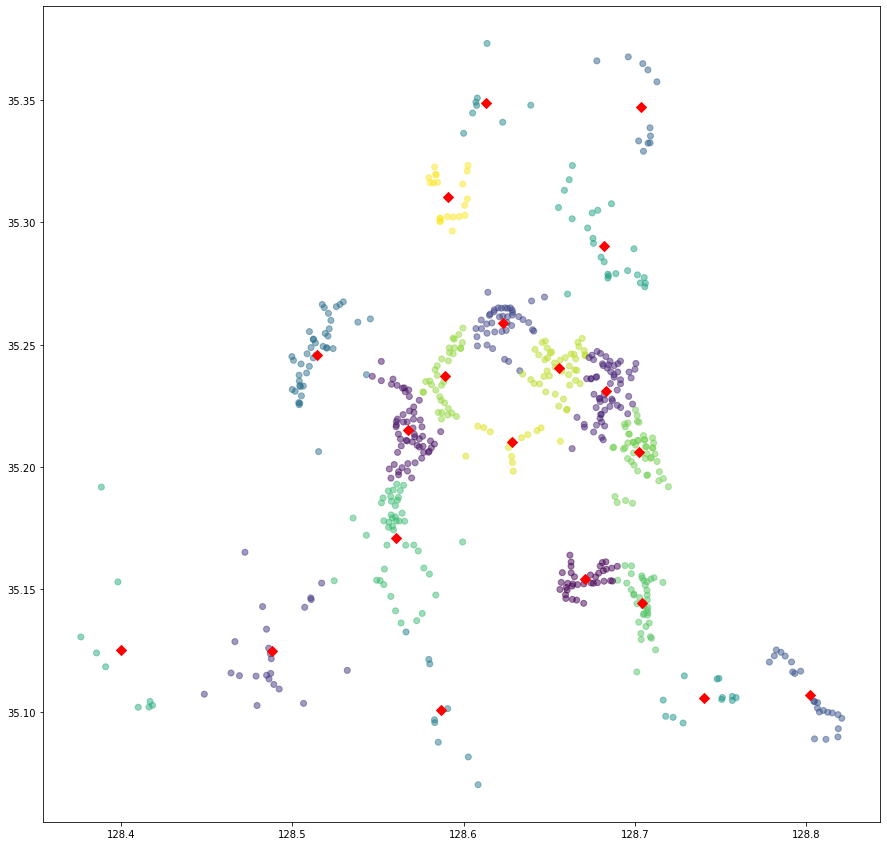

In [ ]:
# clustering 결과 시각화

plt.figure(figsize=(15,15))
plt.scatter(res['x'],res['y'],c=res['predict'],alpha=0.5)
centers = pd.DataFrame(model.cluster_centers_,columns=['x','y'])
center_x = centers['x']
center_y = centers['y']
plt.scatter(center_x,center_y,s=50,marker='D',c='r')
plt.show()

In [ ]:
# 각 그룹별로 가중치 상위 2개 후보 정류소 선정

df_final = pd.concat([df_train[['ID','busStation']],df_train_eq_mms],axis = 1)
df_final = pd.concat([df_final,res[['predict']]],axis = 1)
df_final['number*total'] = df_final['number']+df_final['total']
df_final = df_final.groupby(['predict'])
func = lambda df_final_u:df_final_u.sort_values(by='number*total',ascending = False)[:2]
df_final.apply(func)

ID  busStation         x         y    number     total  \
predict                                                                   
0       543  519802       북원로타리  0.631364  0.272940  0.371115  0.236560   
        557  519704       공설운동장  0.629558  0.263388  0.232907  0.236560   
1       282  407223         회산교  0.436509  0.481184  1.000000  0.417430   
        312  307201       합포주유소  0.438813  0.469251  1.000000  0.417430   
2       131  107509       사림동농협  0.695492  0.571209  0.823035  0.483475   
        100  107503     장애인복지회관  0.678506  0.584575  0.823035  0.483475   
3       469  306606        동전마을  0.316467  0.272019  0.004205  0.632510   
        441  317602   진동유엔아이APT  0.250248  0.169967  0.057404  0.163470   
4       112  115003        향교입구  0.557505  0.643311  0.823035  0.793620   
        185  120602        차룡단지  0.521160  0.591957  0.512249  0.793620   
5       585  512906       용원어시장  0.995435  0.075569  0.232907  0.673541   
        584  630344      신항초등학교  0.979176  0.061261  0.232907  0.673541   
6       246  106821    대산일반산업단지  0.733053  0.868489  0.069104  0.087277   
        239  116513          장등  0.739374  0.854573  0.005667  0.087277   
7       280  422819        신우타워  0.340543  0.647941  0.447898  1.000000   
        336  422818      코오롱아파트  0.335761  0.644935  0.447898  1.000000   
8       372  314806      유산마을입구  0.427378  0.206077  0.064717  0.184750   
        386  301820      구산면사무소  0.458535  0.163010  0.064717  0.039168   
9       129  119347       북면사무소  0.520127  0.916393  0.021207  0.632510   
        143  119345       대호아파트  0.514843  0.906195  0.021207  0.632510   
10      581  505511      해양공원입구  0.778313  0.090945  0.360878  0.168349   
        503  514007         웅천동  0.838596  0.143567  0.148812  0.168349   
11      260  105701       우성아파트  0.726875  0.723019  0.053748  0.297135   
        87   116503       주남저수지  0.679326  0.774934  0.053748  0.297135   
12      442  315220        둔덕종점  0.026944  0.401453  0.005484  0.030530   
        443  303802       진전중학교  0.075392  0.104589  0.005484  0.030530   
13      424  300634         해운동  0.414394  0.355944  0.823035  0.646500   
        430  314704      해운초등학교  0.409729  0.348515  0.360878  0.646500   
14      591  522317      장천초교입구  0.736385  0.195779  0.191225  0.365893   
        576  522312         행암동  0.730644  0.152202  0.191225  0.365893   
15      94   204301   남양성원1차아파트  0.731643  0.464455  1.000000  0.616389   
        230  200405      남산초등학교  0.735716  0.446630  0.823035  0.616389   
16      325  408613    야구장앞홈플러스  0.469693  0.502211  0.512249  0.468270   
        379  411211       대림아파트  0.482957  0.507507  0.512249  0.468270   
17      209  117601     봉곡동상가입구  0.613304  0.575679  0.823035  0.660801   
        158  117606      상북초교후문  0.618597  0.583930  0.823035  0.483475   
18      125  201205        한국철강  0.587312  0.472253  0.268007  0.095387   
        127  201209  세원셀론텍.영흥철강  0.604841  0.481401  0.268007  0.095387   
19      215  103118     힐스테이트4차  0.472012  0.764180  0.187569  0.632510   
        180  103107        덕산아내  0.481631  0.766314  0.187569  0.632510   

             predict  number*total  
predict                             
0       543        0      0.607675  
        557        0      0.469467  
1       282        1      1.417430  
        312        1      1.417430  
2       131        2      1.306510  
        100        2      1.306510  
3       469        3      0.636714  
        441        3      0.220874  
4       112        4      1.616655  
        185        4      1.305869  
5       585        5      0.906448  
        584        5      0.906448  
6       246        6      0.156382  
        239        6      0.092945  
7       280        7      1.447898  
        336        7      1.447898  
8       372        8      0.249466  
        386        8      0.103885  
9       129        9      0.653716  
        143        9      0.653716  
10      581       10      0.529226  
        503    

$$ max(MMX(대수*횟수) + MMX(합계)) $$

* MMX : MinMaxScale

In [ ]:
# K-means training, seed 값 20개

model = KMeans(n_clusters=10,algorithm='auto')
model.fit(df_train_cl)
predict = pd.DataFrame(model.predict(df_train_cl))
predict.columns=['predict']
res = pd.concat([df_train_cl,predict],axis=1)
res

,x,y,predict
0,128.607238,35.256602,0
1,128.632254,35.261516,0
2,128.643917,35.245863,0
3,128.617951,35.264309,0
4,128.659437,35.244778,0
...,...,...,...
597,128.662089,35.164016,1
598,128.670975,35.153762,1
599,128.711163,35.154770,1
600,128.705164,35.143197,1


In [ ]:
# 각 그룹별로 가중치 상위 2개 후보 정류소 선정

df_final = pd.concat([df_train[['ID','busStation']],df_train_eq_mms],axis = 1)
df_final = pd.concat([df_final,res[['predict']]],axis = 1)
df_final['number*total'] = df_final['number']+df_final['total']
df_final = df_final.groupby(['predict'])
func = lambda df_final_u:df_final_u.sort_values(by='number*total',ascending = False)[:4]
df_final.apply(func)

ID  busStation         x         y    number     total  \
predict                                                                   
0       112  115003        향교입구  0.557505  0.643311  0.823035  0.793620   
        209  117601     봉곡동상가입구  0.613304  0.575679  0.823035  0.660801   
        158  117606      상북초교후문  0.618597  0.583930  0.823035  0.483475   
        142  117603      상북초교정문  0.617190  0.582322  0.823035  0.483475   
1       543  519802       북원로타리  0.631364  0.272940  0.371115  0.236560   
        591  522317      장천초교입구  0.736385  0.195779  0.191225  0.365893   
        576  522312         행암동  0.730644  0.152202  0.191225  0.365893   
        581  505511      해양공원입구  0.778313  0.090945  0.360878  0.168349   
2       424  300634         해운동  0.414394  0.355944  0.823035  0.646500   
        430  314704      해운초등학교  0.409729  0.348515  0.360878  0.646500   
        414  314702     월영아파트종점  0.410927  0.343704  0.359049  0.646500   
        415  300636  경남대남부터미널종점  0.409319  0.359741  0.359049  0.646500   
3       94   204301   남양성원1차아파트  0.731643  0.464455  1.000000  0.616389   
        230  200405      남산초등학교  0.735716  0.446630  0.823035  0.616389   
        100  107503     장애인복지회관  0.678506  0.584575  0.823035  0.483475   
        102  113308       도립미술관  0.705529  0.556761  0.823035  0.483475   
4       471  317701     진동면허시험장  0.249058  0.176654  0.057404  0.163470   
        441  317602   진동유엔아이APT  0.250248  0.169967  0.057404  0.163470   
        440  317703        덕기마을  0.246828  0.184285  0.012066  0.163470   
        470  306308          고현  0.231529  0.106901  0.005667  0.163470   
5       585  512906       용원어시장  0.995435  0.075569  0.232907  0.673541   
        584  630344      신항초등학교  0.979176  0.061261  0.232907  0.673541   
        570  513005         반짓골  0.987424  0.096867  0.148812  0.673541   
        563  513007      용원초등학교  0.995028  0.094586  0.148812  0.673541   
6       282  407223         회산교  0.436509  0.481184  1.000000  0.417430   
        311  307202       노비산입구  0.438286  0.472793  1.000000  0.417430   
        312  307201       합포주유소  0.438813  0.469251  1.000000  0.417430   
        310  307203     북마산가구거리  0.441940  0.457758  1.000000  0.295706   
7       260  105701       우성아파트  0.726875  0.723019  0.053748  0.297135   
        87   116503       주남저수지  0.679326  0.774934  0.053748  0.297135   
        184  104651        덕천마을  0.692574  0.688762  0.009506  0.297135   
        242  104619          석산  0.635491  0.801908  0.009506  0.297135   
8       196  103108       감계중학교  0.472475  0.760246  0.187569  0.632510   
        244  103113      중방마을회관  0.488090  0.746987  0.187569  0.632510   
        250  103117    천수림아파트정문  0.472376  0.764158  0.187569  0.632510   
        215  103118     힐스테이트4차  0.472012  0.764180  0.187569  0.632510   
9       280  422819        신우타워  0.340543  0.647941  0.447898  1.000000   
        336  422818      코오롱아파트  0.335761  0.644935  0.447898  1.000000   
        485  422825       평성사거리  0.344907  0.651496  0.447898  1.000000   
        338  422814        호계농협  0.328648  0.626411  0.447898  1.000000   

             predict  number*total  
predict                             
0       112        0      1.616655  
        209        0      1.483836  
        158        0      1.306510  
        142        0      1.306510  
1       543        1      0.607675  
        591        1      0.557118  
        576        1      0.557118  
        581        1      0.529226  
2       424        2      1.469535  
        430        2      1.007378  
        414        2      1.005550  
        415        2      1.005550  
3       94         3      1.616389  
        230        3      1.439424  
        100        3      1.306510  
        102        3      1.306510  
4       471        4      0.220874  
        441        4      0.220874  
        440        4      0.175536  
        470        4      0.169137  
5       585        5      0.906448  
        584    